<a href="https://colab.research.google.com/github/AnilKumar-06/Movie-Recommandation/blob/main/NetflixRecommandationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [56]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('nbagg')

import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [57]:
start = datetime.now()
if not os.path.isfile('data.csv'):
  data = open('data.csv', mode='w')
  row = list()
  files = ['/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_1.txt','/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_2.txt', '/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_3.txt', '/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_4.txt']

  for file in files:
    print('Reading rating from {}...'.format(file))
    with open(file) as f:
      for line in f:
        del row[:] #you don't have to do this
        line = line.strip()
        if line.endswith(':'):
          #all below are rating for this movie, until another
          movie_id = line.replace(':', '')
        else:
          row = [x for x in line.split(',')]
          row.insert(0, movie_id)
          data.write(','.join(row))
          data.write('\n')

    print('Done.\n')
  data.close()
  print('Time taken :',datetime.now() - start)

In [58]:
print("Creating the dataframe from data.csv file...")
df = pd.read_csv('data.csv', sep=',',names = ['movie', 'user', 'rating', 'date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

#arranging the rating according to time
print('Sorting the datetime by date...')
df.sort_values(by='date', inplace=True)
print('Done..')

Creating the dataframe from data.csv file...
Done.

Sorting the datetime by date...
Done..


In [59]:
df.head()

,movie,user,rating,date


In [54]:
df.describe()['rating']

count       0
unique      0
top       NaN
freq      NaN
Name: rating, dtype: object

In [48]:
# Just to make sure that all NAN containing rows are deleted..

print("Number of Nan values in our dataframe : ", sum(df.isnull().any()))

Number of Nan values in our dataframe :  0


Removing Duplicates

In [ ]:
dup_bool = df.duplicated(['movie', 'user', 'rating'])
dups = sum(dup_bool) #by considering all columns..(including timestamp)
print("There are {} duplicate rating entries in the data...".format(dups))

There are 0 duplicate rating entries in the data...


Basic Statistics(# of Rating, # of Users, # of Movies)

In [ ]:
print("Total Data")
print("-"*70)
print("\nTotal no. of rating : ",df.shape[0])
print("Total No. of Users : ", len(np.unique(df.user)))
print("Total No. of Movies : ", len(np.unique(df.movie)))

Total Data
----------------------------------------------------------------------

Total no. of rating :  0
Total No. of Users :  0
Total No. of Movies :  0


Spliting data into Train and Test

In [ ]:
if not os.path.isfile('train.csv'):
  #create the dataframe and store it in the disk for offline purpose...
  df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
  #creating the dataframe and store it in the disk for offline purpose...
  df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index = False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

Basic statistic in Train data (# of Ratings # of Users and # of Movies)

In [ ]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data")
print("-"*70)
print("\nTotal no of ratings : ",test_df.shape[0])
print("Total no of Users : ", len(np.unique(test_df.user)))
print("Total no. of movies : ", len(np.unique(test_df.movie)))

Training data
----------------------------------------------------------------------

Total no of ratings :  0
Total no of Users :  0
Total no. of movies :  0


EDA On Train data

In [ ]:
def human(num, units = "M"):
  units = units.lower()
  num = float(num)
  if units == 'k':
    return str(num/10**3) + 'K'
  elif units == 'M':
    return str(num/10**6) + 'M'
  elif units == 'b':
    return str(num/10**9) + 'B'


Distribution of ratings

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ValueError: ignored

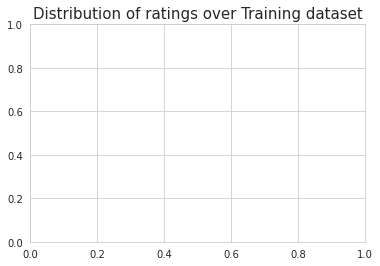

In [ ]:
fig, ax = plt.subplots()
plt.title("Distribution of ratings over Training dataset", fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel("No. of ratings(Millions)")
plt.show()

In [ ]:
# It is used to skip the warnings 'SettingWithCopyWarning'...
pd.options.mode.chained_assignment = None        #default = 'warn'
train_df['day_of_week'] = train_df.date.dt.day_name()
#df['day_of_week'] = df['mydate'].dt.day_name() 
train_df.head(20)



,movie,user,rating,date,day_of_week
0,1367,510180,5,1999-11-11,Thursday
1,5625,510180,4,1999-11-11,Thursday
2,3730,510180,4,1999-11-11,Thursday
3,1798,510180,5,1999-11-11,Thursday
4,8357,510180,4,1999-11-11,Thursday
5,8079,510180,2,1999-11-11,Thursday
6,5571,510180,4,1999-11-11,Thursday
7,6615,510180,5,1999-11-11,Thursday
8,3870,510180,2,1999-11-11,Thursday
9,9003,510180,3,1999-11-11,Thursday


In [ ]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count()
no_of_rated_movies_per_user.head()

user
6     219
7     433
10     99
25      2
33     14
Name: rating, dtype: int64

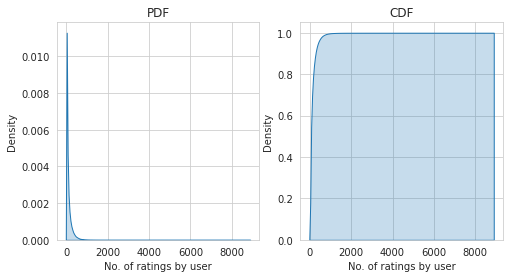

In [ ]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel("No. of ratings by user")
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True, ax=ax2)
plt.xlabel("No. of ratings by user")
plt.title('CDF')
plt.show()

In [ ]:
no_of_rated_movies_per_user.describe()

count    398674.000000
mean        102.402173
std         150.371995
min           1.000000
25%          17.000000
50%          46.000000
75%         127.000000
max        8868.000000
Name: rating, dtype: float64

In [ ]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0, 1.01, 0.01))

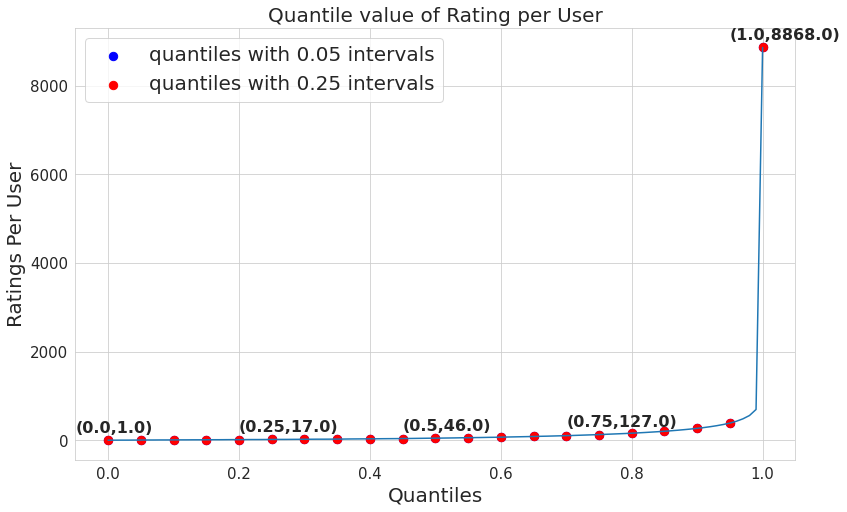

In [ ]:
fig = plt.figure(figsize = (10, 6))
axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_title("Quantile value of Rating per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y=quantiles.values[::5], c='blue', s=70, label="quantiles with 0.05 intervals")

plt.scatter(x = quantiles.index[::5], y=quantiles.values[::5], c="red", s=70, label = "quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):plt.annotate(s='({},{})'.format(x,y), xy = (x,y),fontweight
                                                                            ='bold', fontsize = 16, xytext=(x-0.05, y+180))

axes.tick_params(labelsize = 15)

In [ ]:
quantiles[::5]

0.00       1.0
0.05       4.0
0.10       7.0
0.15      10.0
0.20      13.0
0.25      17.0
0.30      21.0
0.35      25.0
0.40      31.0
0.45      38.0
0.50      46.0
0.55      57.0
0.60      69.0
0.65      84.0
0.70     103.0
0.75     127.0
0.80     159.0
0.85     202.0
0.90     268.0
0.95     387.0
1.00    8868.0
Name: rating, dtype: float64

In [ ]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 303583
Total number of ratings above 75th percentile = 95091


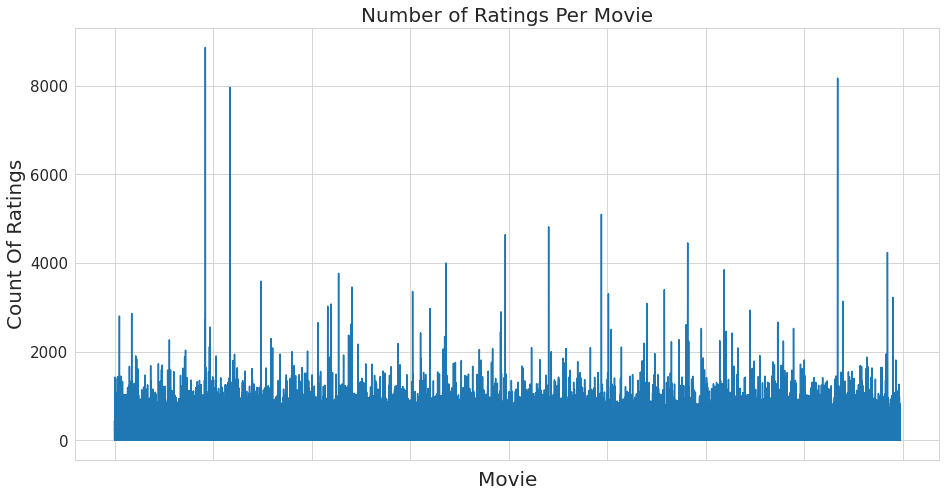

In [ ]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize=20)
plt.ylabel("Count Of Ratings", fontsize=20)
plt.plot(no_of_rated_movies_per_user.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

**It is skewed nicely**

It clearly shows that there are some movies which are very popular and were rated by 90% users as comapared to other movies

Number of ratings on each day of the week

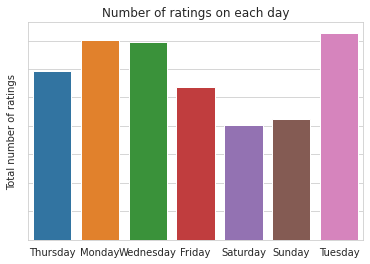

In [ ]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data = train_df, ax = ax)
plt.title("Number of ratings on each day")
plt.ylabel('Total number of ratings')
plt.xlabel("")
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

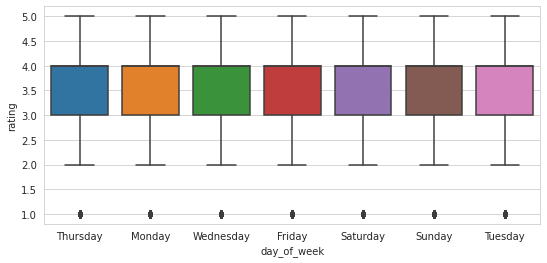

0:00:21.023743


In [ ]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now()-start)

In [ ]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print('Average Ratings')
print("_"*30)
print(avg_week_df)
print("\n")

Average Ratings
______________________________
day_of_week
Friday       3.572173
Monday       3.567473
Saturday     3.583005
Sunday       3.582832
Thursday     3.572752
Tuesday      3.565787
Wednesday    3.575152
Name: rating, dtype: float64




Creating sparse matrix from data frame

In [ ]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
  print("It is present in your pwd, getting it from disk......")
  #just get it from the disk instead of computing it
  train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
  print("Done...")

else:
  print("We are creating sparse matrix from the dataframe.....")
  #create sparse matrix and store it after usages.
  #It should be in such a way that, Matrix[row, col] = data
  train_sparse_matrix = sparse.csr_matrix((train_df.rating.values,(train_df.user.values, train_df.movie.values)),)
  print("Done. It\'s shape is : (user, movie", train_sparse_matrix.shape)
  print("Saving it into disk for further usages...")
  sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
  print("Done.....\n")
  print(datetime.now()-start)

We are creating sparse matrix from the dataframe.....
Done. It's shape is : (user, movie (2649430, 9211)
Saving it into disk for further usages...
Done.....

0:00:33.080262


The sparsity of train sparse matrix

In [ ]:
us, mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()
print("Sparsity of train matrix : {} % ".format((1-elem/(us*mv))*100))

Sparsity of train matrix : 99.83271081896056 % 


Creating sparse matrix from test data frame

In [ ]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
  print("It is present in your pwd, getting it from disk....")
  #just get it from the disk instead of computing it.
  test_sparse_matrix = sparse.load_npz("test_sparse_matrix.npz")
  print("Done....")
else:
  print("We are creating sparse matrix from the dataframe....")
  #create sparse_matrix and store it for after usages
  #It should be in such a way that, matrix[row, col] = data
  test_sparse_matrix = sparse.csr_matrix((test_df.rating.values,(test_df.user.values, test_df.movie.values)),)
  print("Done. It\'s shape is : (user, movie):", test_sparse_matrix.shape)
  print("Saving it into disk for further usages....")
  #save it into disk
  sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
  print('Done...\n')
print(datetime.now()-start)

We are creating sparse matrix from the dataframe....
Done. It's shape is : (user, movie): (2649430, 9211)
Saving it into disk for further usages....
Done...

0:00:09.518644


The sparsity of test data matrix

In [ ]:
us, mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()
print("sparsity of Test matrix : {} % ".format((1-elem/(us*mv))*100))

sparsity of Test matrix : 99.95817770474015 % 


Finding Global Average of all movies ratings, Averages rating per user, and average rating per movie

In [ ]:
#get the averages in dictionary(key:user_id/movie_id, value:avg rating)
def get_average_rating(sparse_matrix, of_users):
  #average rating of user/axes
  ax = 1 if of_users else 0 #1-user axes, 0-Movie axes
  #".AI" is for converting column_matrix to 1-D numpy array
  sum_of_ratings = sparse_matrix.sum(axis=ax).AI
  #Boolean matrix of ratings(whether a user rated movie or not)
  is_rated = sparse_matrix != 0
  #no. of ratings that each user or movie
  no_of_ratings = is_rated.sum(axis=ax).AI
  #max_user and max_movie ids in sparse matrix
  u, m = sparse_matrix.shape
  #create a dictionary of users and their averages ratings..
  averages_ratings = { i :sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i] != 0}
  #return that dictionary of average rating

Finding global average of all movie ratings

In [ ]:
train_averages = dict()
#get the global avetrage of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

NameError: ignored

Finding average rating per users

In [ ]:
train_averages['user'] = get_average_rating(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 : ', train_averages['user'][10])

NameError: ignored

Finding average rating per movie

In [ ]:
train_averages['movie'] = get_average_rating(train_sparse_matrix, of_users=True)
print('\nAverages rating of movie 15 :',train_averages['movie'][15])

NameError: ignored

PDF's & CDF's of Avg ratings of users and movies(In Train data)